In [1]:
import numpy as np
import random
import igraph

In [20]:
def generate_random_spatial_graph(N, lambda_d, rho, uniform_population=True):
    """
    generates a random spatial graph.
    @param: n the number of nodes in the graph.
    @param: lambda_d the mixing constant.
    @param: rho the edge density constant.
    @param: uniform_population use a uniform population. By default uniform_population is true.
    @return: node_communities
    @return: node_populations
    @return: node_locations
    @return: adj_matrix
    """
    
    L = int(rho * N * (N - 1) / 2)  # number of edges
    node_communities = np.zeros(N)  # array to hold communities
    
    community_indices = np.arange(N, dtype=int)  # indices of nodes for community assignment
    random.shuffle(community_indices)
    
    np.put(node_communities, community_indices[:N//2], 1)
    
    if uniform_population:
        node_populations = np.ones(N, dtype=int) * 100  # set the population at all nodes to 100
    else:
        node_populations = np.random.choice(np.arange(1, 101, dtype=int), N)
        
    node_locations = np.random.uniform(0, 100, size=(N, 2))  # generate random locations in a 100x100 area
    
    adj_matrix = np.zeros((N, N))
    
    number_of_edges = 0
    
    # add the L edges, multiple edges are treated as weights
    # the graph is undirected
    while number_of_edges < L:
        for i in range(N):
            for j in range(N):
                if j != i:
                    lam = lambda_d

                    if node_communities[i] == node_communities[j]:
                        lam = 1

                    dist = np.linalg.norm(node_locations[i] - node_locations[j])

                    if np.random.rand() < lam/dist:
                        adj_matrix[i, j] += 1
                        number_of_edges += 1

                        if number_of_edges == L:
                            break
            else:
                continue
            break
    
    max_value = np.max(adj_matrix)
    
    adj_matrix = adj_matrix / max_value
    
    return node_communities, node_populations, node_locations, adj_matrix

In [34]:
node_communities, node_populations, node_locations, adj_matrix = \
    generate_random_spatial_graph(50, 0.2, 0.5, uniform_population=False)

g = igraph.Graph.Weighted_Adjacency(adj_matrix.tolist(), mode=igraph.ADJ_DIRECTED, 
                                    attr="weight", loops=False)

# edge_list = adj_matrix.stack().reset_index()  # convert to edge list
# edge_list = edge_list.values.tolist()

# # g = igraph.Graph.Adjacency(adj_matrix.astype(bool).tolist())
# g = igraph.Graph.TupleList(edge_list, directed=False, edge_attrs=['weight'])
# g.es.select(weight=0).delete()
g.vs['weight'] = node_populations
g.vs['true_community'] = node_communities

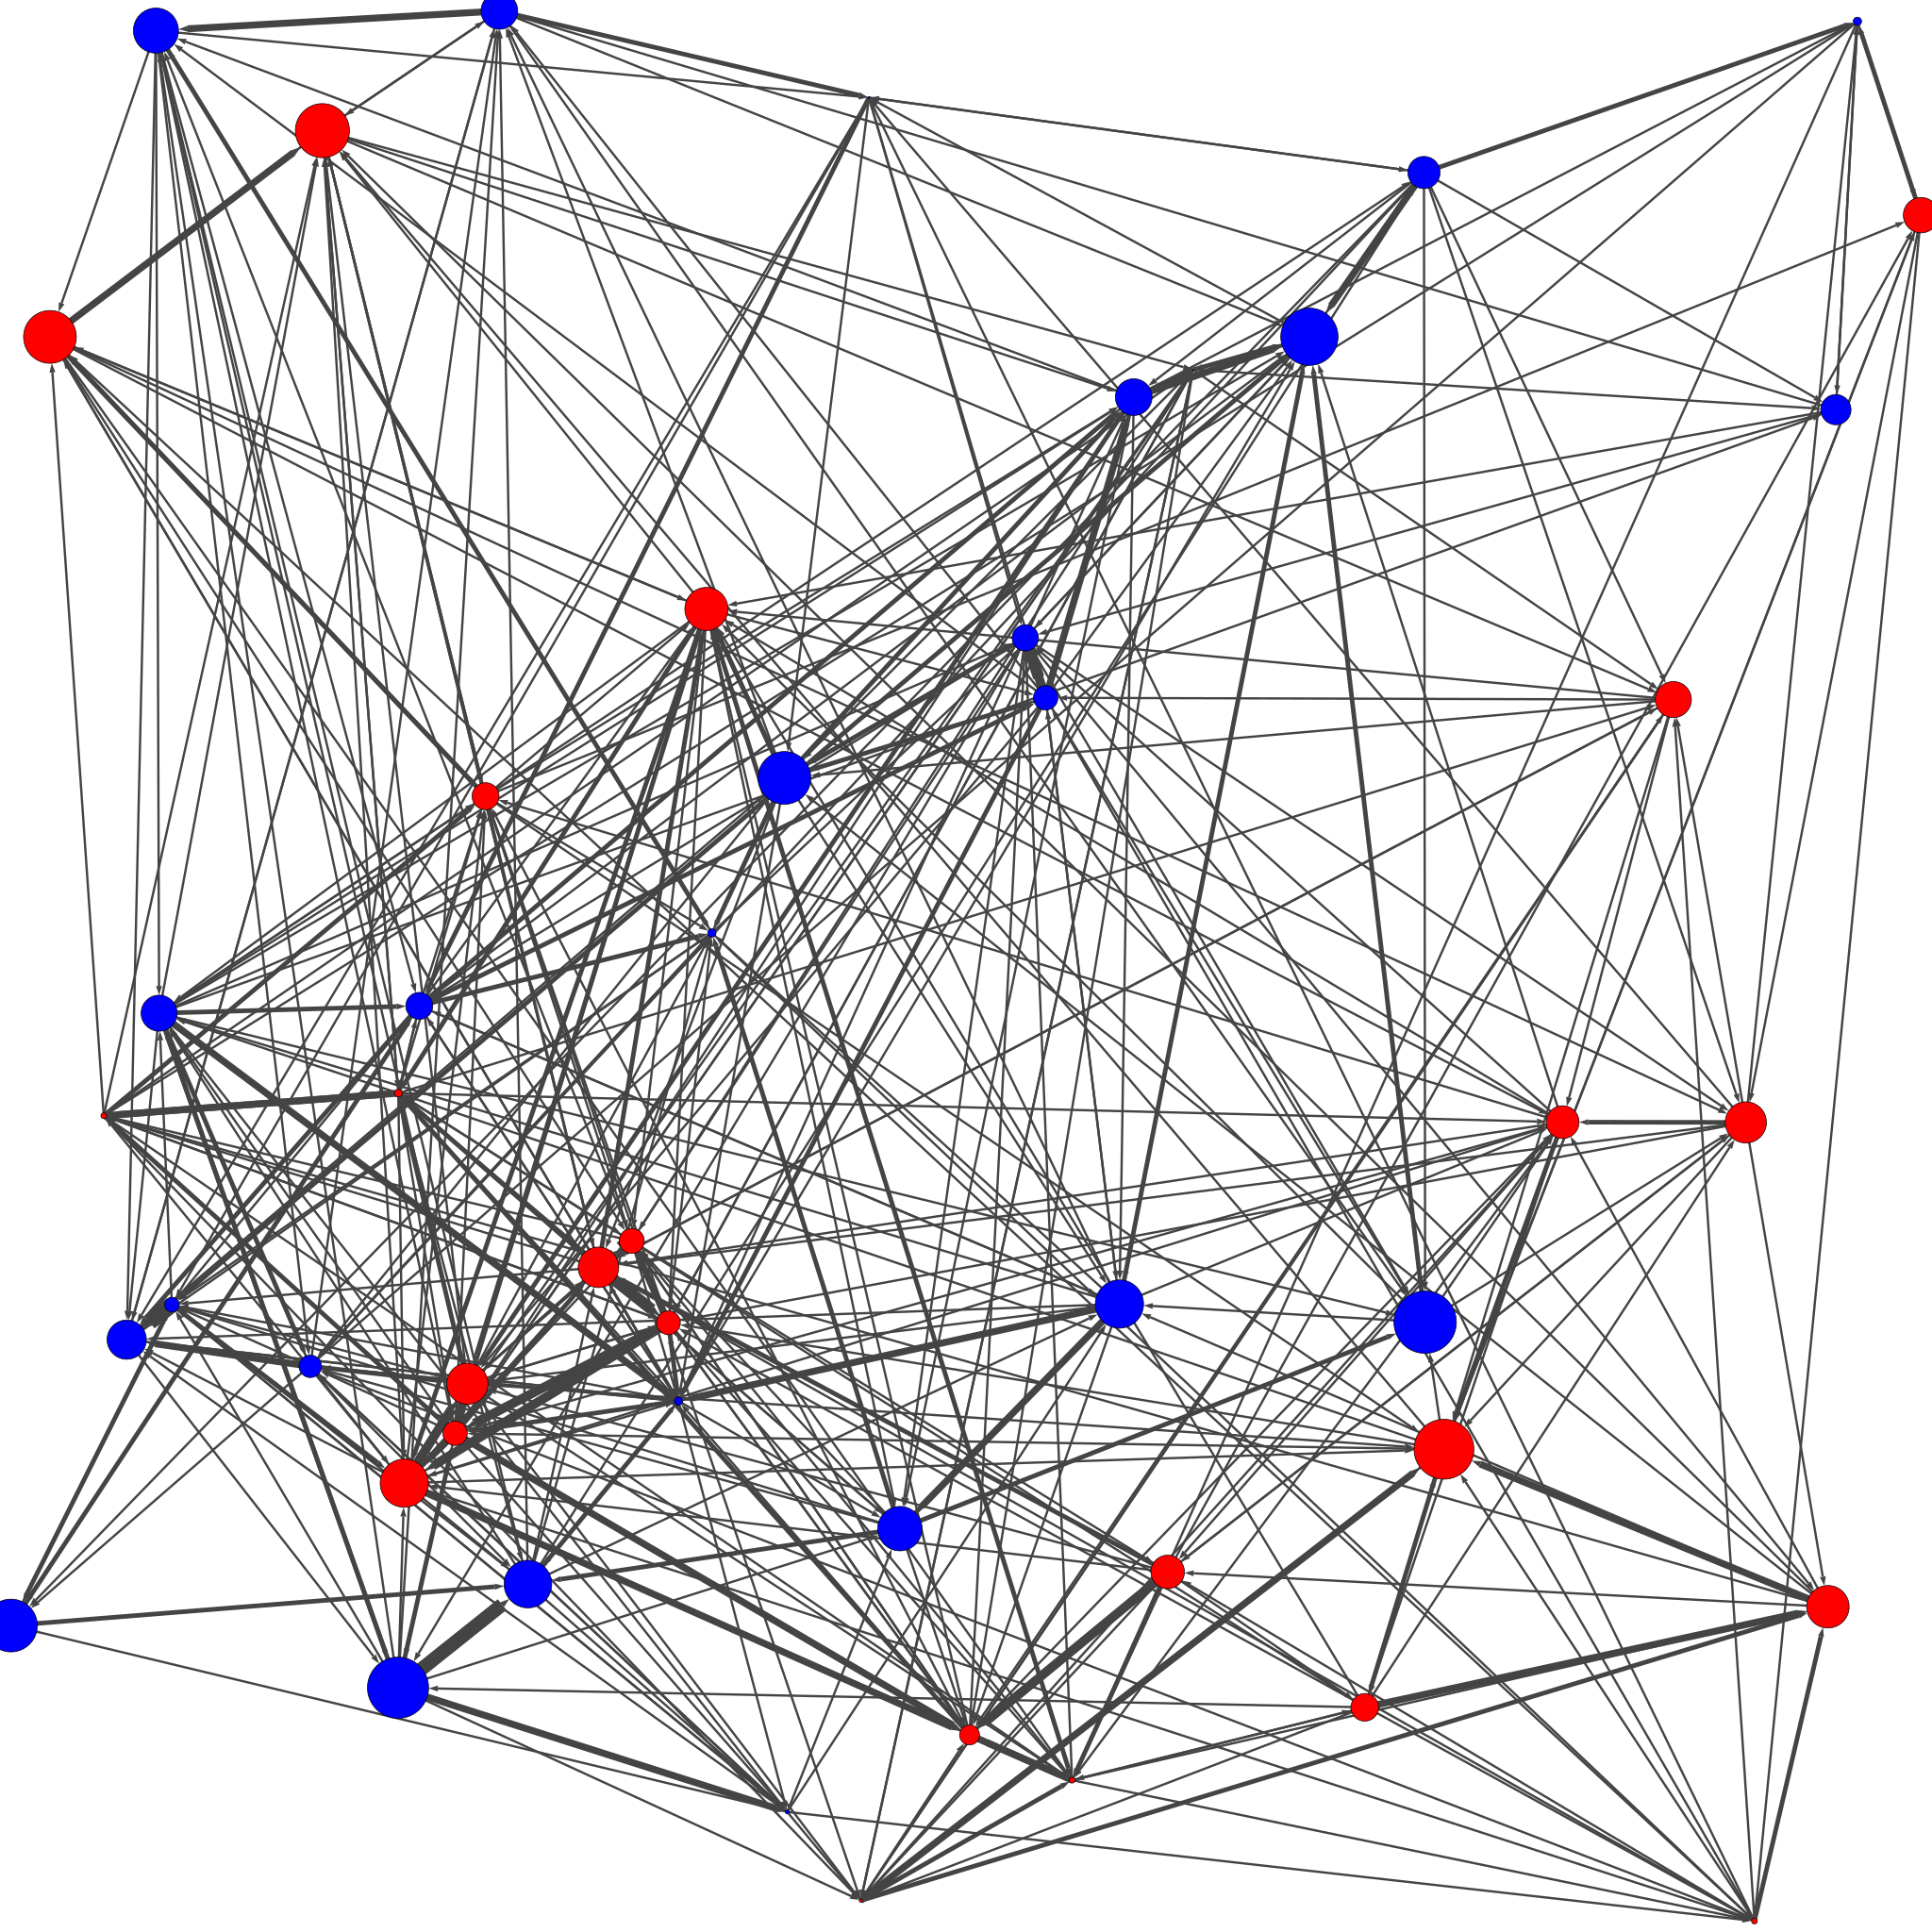

In [35]:
out_fig_name = "graph.eps"

visual_style = {}

# Define colors used for outdegree visualization
colours = ['#fecc5c', '#a31a1c']

# Set bbox and margin
visual_style["bbox"] = (3000,3000)
visual_style["margin"] = 17

vertex_colors = ['blue' if i == 1 else 'red' for i in g.vs['true_community']]

# Set vertex colours
visual_style["vertex_color"] = vertex_colors

# Set vertex size
visual_style["vertex_size"] = g.vs['weight']

# Set vertex lable size
visual_style["vertex_label_size"] = 8

# Don't curve the edges
visual_style["edge_curved"] = False

edge_widths = np.array(g.es['weight']) * 25

visual_style["edge_width"] = edge_widths

# Set the layout
# layout = g.layout_fruchterman_reingold()
layout = igraph.Layout(node_locations.tolist())
visual_style["layout"] = layout

# Plot the graph
igraph.plot(g, out_fig_name, **visual_style)

In [36]:
info_map_clustering = \
    g.community_infomap(edge_weights=g.es['weight'], vertex_weights=g.vs['weight'], trials=20)
true_clustering = igraph.clustering.VertexClustering.FromAttribute(g, 'true_community')

In [37]:
info_map_clustering.membership

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [27]:
igraph.compare_communities(true_clustering, info_map_clustering, method='vi')

0.6931471805599453